In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cgiar-crop-damage-classification/test.csv
/kaggle/input/cgiar-crop-damage-classification/sol/ab79912e70d6f5cd30f6cf58c31c9ea9025a210f.jpg
/kaggle/input/cgiar-crop-damage-classification/sol/66afa71daaa249fbc84d26e0f0d4d1335f7e4040.jpg
/kaggle/input/cgiar-crop-damage-classification/sol/b7e0d2b32652fec3607a2cec24d8290026131f53.jpg
/kaggle/input/cgiar-crop-damage-classification/sol/d0fb195fad19ed83bd93d310c51738b7b870e693.jpg
/kaggle/input/cgiar-crop-damage-classification/sol/2905868b0ad57bc0ad2b946fe9f29782fb7ae9b5.jpg
/kaggle/input/cgiar-crop-damage-classification/sol/5827e106d820a4e8d2ce61d5e378d93c82d16da6.jpg
/kaggle/input/cgiar-crop-damage-classification/sol/070e3029428d5dc01e48d22d831458593d9660a1.jpg
/kaggle/input/cgiar-crop-damage-classification/sol/c973fd20e87e5b81e62338bc57c01e4cfc400aa2.jpg
/kaggle/input/cgiar-crop-damage-classification/sol/d1f26d0836d77c5738efa6576d315c2d4529cf8d.jpg
/kaggle/input/cgiar-crop-damage-classification/sol/1932accceda11deae0fa525d83082

In [2]:
import matplotlib.pyplot as plotter_lib
import numpy as np
import PIL as image_lib
import tensorflow as tf
# from keras.layers.core import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

2024-07-17 13:51:31.721564: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-17 13:51:31.721689: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-17 13:51:31.856215: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
data_directory = "/kaggle/input/cgiar-crop-damage-classification/train"

In [5]:
img_height,img_width=180,180
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_directory,
                                                                    validation_split=0,
#                                                                     subset="training",
                                                                    seed=123,
                                                                    label_mode='categorical',
                                                                    image_size=(img_height, img_width),
                                                                    batch_size=batch_size)

Found 20854 files belonging to 5 classes.


In [6]:
data_directory = "/kaggle/input/cgiar-crop-damage-classification/test"

In [7]:
validation_ds = tf.keras.preprocessing.image_dataset_from_directory( data_directory,
#                                                                         validation_split=1,
#                                                                         subset="validation",
                                                                        seed=123,
                                                                        label_mode='categorical',
                                                                        image_size=(img_height, img_width),
                                                                        batch_size=batch_size)

Found 5214 files belonging to 5 classes.


tf.Tensor([0. 0. 0. 1. 0.], shape=(5,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0.], shape=(5,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0.], shape=(5,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0.], shape=(5,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0.], shape=(5,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0.], shape=(5,), dtype=float32)


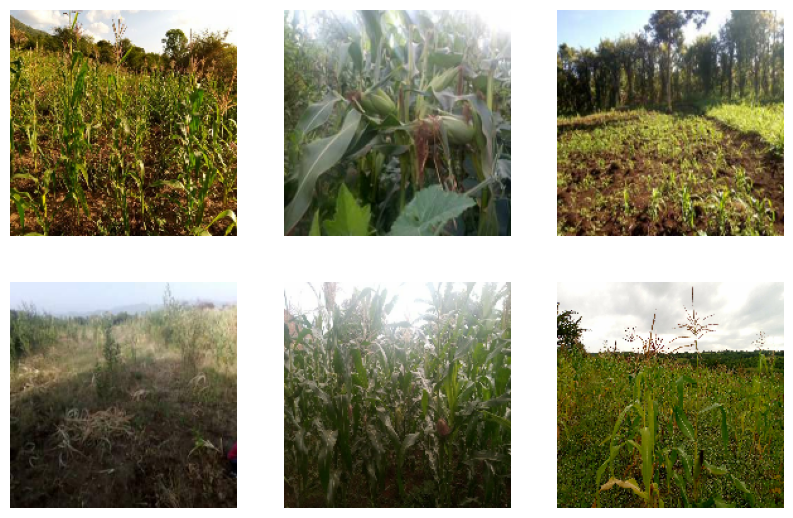

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
epochs=10
for images, labels in train_ds.take(1):
    for var in range(6):
        ax = plotter_lib.subplot(3, 3, var + 1)
        plt.imshow(images[var].numpy().astype("uint8"))
        plt.axis("off")
        print(labels[var])

## Tuning

In [ ]:
import optuna
from optuna.integration import TFKerasPruningCallback

def objective(trial):
    num_conv_layers = trial.suggest_int('num_conv_layers', 1, 3)
    filters = trial.suggest_categorical('filters', [16, 32, 64])
    kernel_size = trial.suggest_int('kernel_size', 3, 5)
    dense_units = trial.suggest_int('dense_units', 64, 256)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epochs = 10  # You can adjust this based on your dataset and computational power
    
    model = create_model(num_conv_layers, filters, kernel_size, dense_units, dropout_rate)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    
    model.fit(x_train, y_train, validation_data=(x_test, y_test),
              batch_size=batch_size, epochs=epochs, verbose=0,
              callbacks=[TFKerasPruningCallback(trial, 'val_accuracy')])
    
    score = model.evaluate(x_test, y_test, verbose=0)
    return score[1]  # Return validation accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial
print(f"  Accuracy: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


In [ ]:
import json
with open('best_params.json', 'w') as json_file:
    json.dump(trial.params, json_file)


## Model

In [72]:
with open('best_params.json', 'r') as json_file:
    best_params = json.load(json_file)
best_params

{'num_conv_layers': 2,
 'filters': 32,
 'kernel_size': 3,
 'dense_units': 128,
 'dropout_rate': 0.43,
 'learning_rate': 0.0001,
 'batch_size': 128}

In [11]:
height, width, channels = 180,180,3

In [12]:
num_conv_layers = best_params["num_conv_layers"]
filters = best_params["filters"]
kernel_size = best_params["kernel_size"]
dense_units = best_params["dense_units"]
dropout_rate = best_params["dropout_rate"]
learning_rate = best_params["learning_rate"]
epochs = 25

In [24]:
def create_model(num_conv_layers, filters, kernel_size, dense_units, dropout_rate):
    model = Sequential()
    model.add(Conv2D(filters=filters, kernel_size=(kernel_size, kernel_size), activation='relu', input_shape=(height, width, channels)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    for _ in range(num_conv_layers):
        model.add(Conv2D(filters=filters*(_+1), kernel_size=(kernel_size, kernel_size), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(5, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [31]:
model = create_model(num_conv_layers, filters, kernel_size, dense_units, dropout_rate)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [32]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 87, 87, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 43, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 41, 41, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,276,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,306,213 (12.61 MB)

 Trainable params: 3,306,213 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

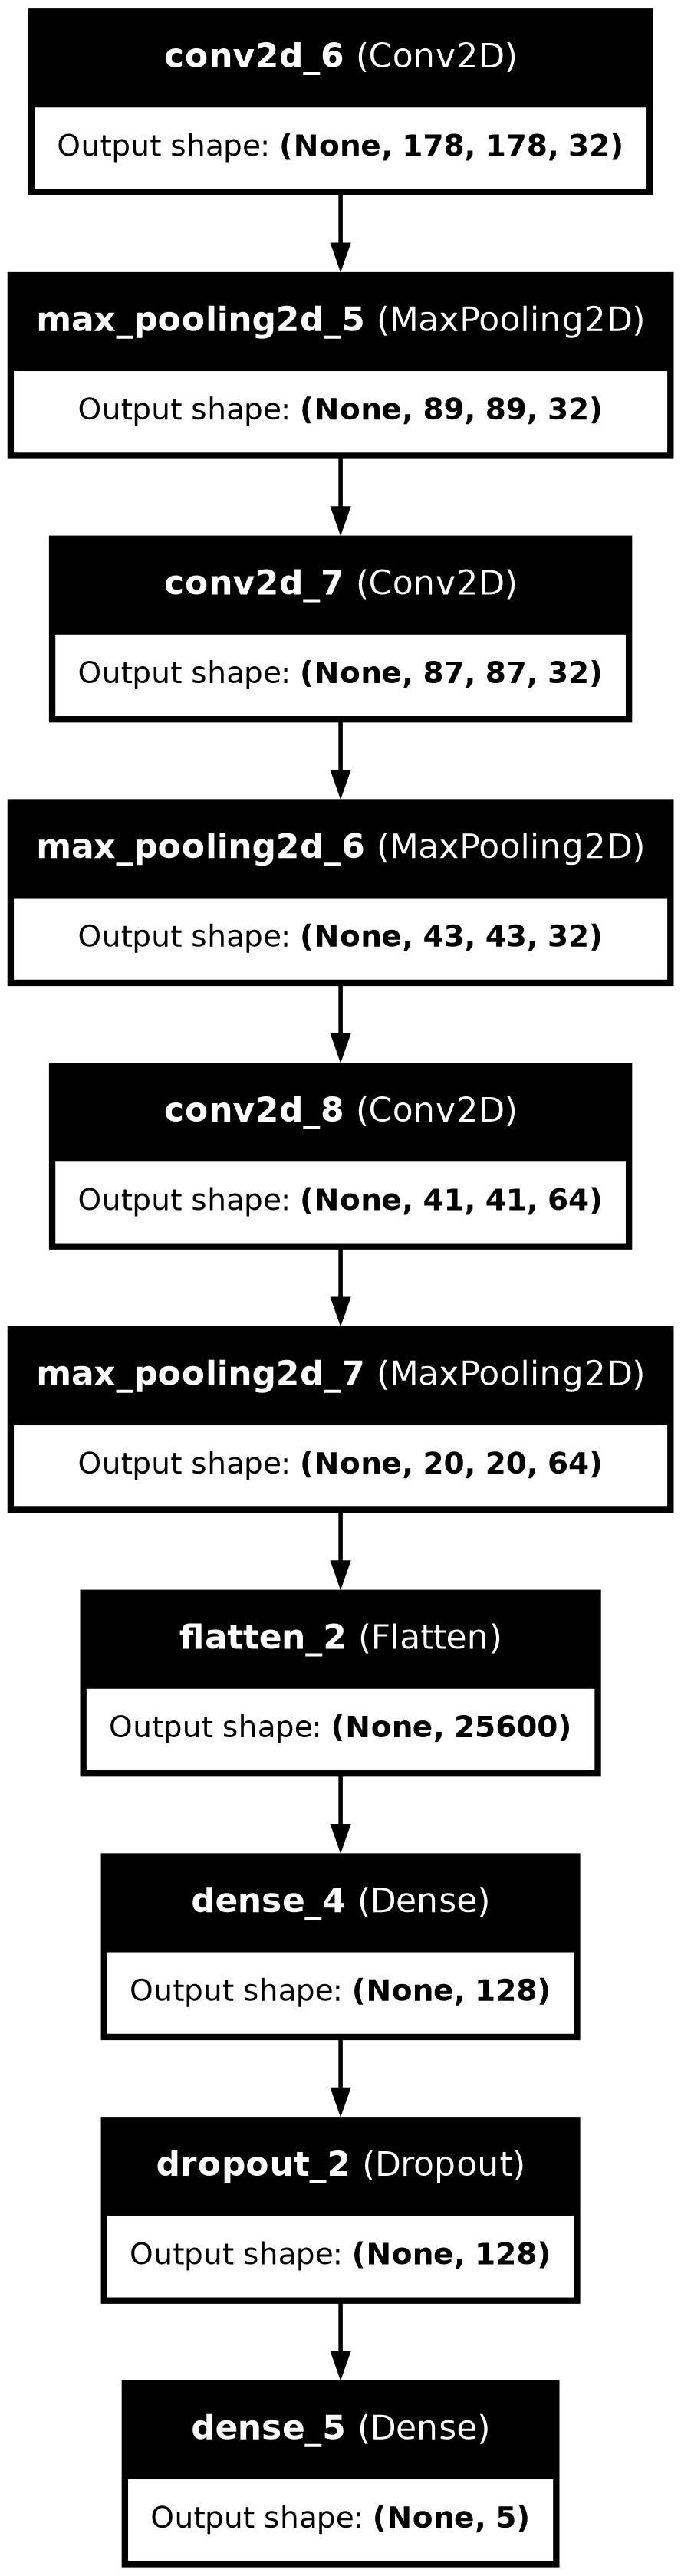

In [27]:
from tensorflow.keras.utils import plot_model              
plot_model(model, show_shapes=True, show_layer_names=True)

In [40]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds,
                    validation_data=validation_ds,
                    epochs=epochs,
                    batch_size=best_params['batch_size'],
                    callbacks=[early_stopping])


Epoch 1/25
652/652 ━━━━━━━━━━━━━━━━━━━━ 161s 238ms/step - accuracy: 0.4032 - loss: 3.2775 - val_accuracy: 0.4459 - val_loss: 1.2216
Epoch 2/25
652/652 ━━━━━━━━━━━━━━━━━━━━ 151s 228ms/step - accuracy: 0.4480 - loss: 1.3130 - val_accuracy: 0.4457 - val_loss: 1.1172
Epoch 3/25
652/652 ━━━━━━━━━━━━━━━━━━━━ 152s 231ms/step - accuracy: 0.4410 - loss: 1.2516 - val_accuracy: 0.4731 - val_loss: 0.9120
Epoch 4/25
652/652 ━━━━━━━━━━━━━━━━━━━━ 149s 226ms/step - accuracy: 0.4557 - loss: 1.1541 - val_accuracy: 0.5825 - val_loss: 0.8484
Epoch 5/25
652/652 ━━━━━━━━━━━━━━━━━━━━ 146s 222ms/step - accuracy: 0.5009 - loss: 1.0661 - val_accuracy: 0.5968 - val_loss: 0.7025
Epoch 6/25
652/652 ━━━━━━━━━━━━━━━━━━━━ 149s 226ms/step - accuracy: 0.5469 - loss: 0.9963 - val_accuracy: 0.6666 - val_loss: 0.5818
Epoch 7/25
652/652 ━━━━━━━━━━━━━━━━━━━━ 149s 225ms/step - accuracy: 0.5839 - loss: 0.9289 - val_accuracy: 0.6852 - val_loss: 0.5560
Epoch 8/25
652/652 ━━━━━━━━━━━━━━━━━━━━ 149s 226ms/step - accuracy: 0.6305 -

In [73]:
model.save("model.h5")

In [62]:
from tensorflow.keras.models import load_model

loaded_model = load_model("model.h5")

In [63]:
label_names = {
    0: 'Drought',
    1: 'Good Growth',
    2: 'Nutrient Deficient',
    3: 'Weed',
    4: 'Other'
}

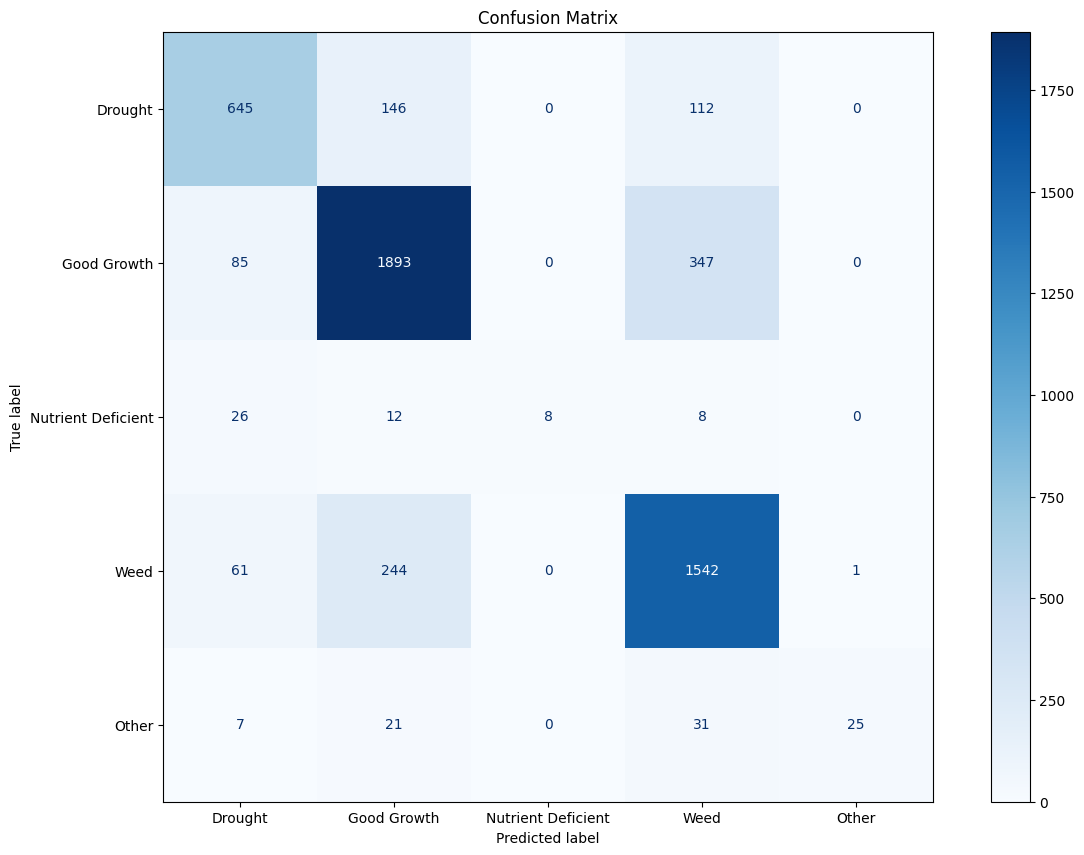

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = []
y_pred = []

for x_val, y_val in validation_ds:
    batch_pred = loaded_model.predict(x_val, verbose=0)
    batch_pred_classes = np.argmax(batch_pred, axis=1)
    
    y_true.extend(np.argmax(y_val, axis=1))  # Assuming y_val is one-hot encoded
    y_pred.extend(batch_pred_classes)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(15, 10))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names.values())
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())  # Use the current axes created by plt.figure

plt.title('Confusion Matrix')
plt.show()

In [66]:
cm

array([[ 645,  146,    0,  112,    0],
       [  85, 1893,    0,  347,    0],
       [  26,   12,    8,    8,    0],
       [  61,  244,    0, 1542,    1],
       [   7,   21,    0,   31,   25]])

In [45]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=label_names.values())
print(report)



                    precision    recall  f1-score   support

           Drought       0.78      0.71      0.75       903
       Good Growth       0.82      0.81      0.82      2325
Nutrient Deficient       1.00      0.15      0.26        54
              Weed       0.76      0.83      0.79      1848
             Other       0.96      0.30      0.45        84

          accuracy                           0.75      5214
         macro avg       0.86      0.56      0.61      5214
      weighted avg       0.80      0.75      0.75      5214



In [46]:
report_dict = classification_report(y_true, y_pred, target_names=label_names.values(), output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df

Class  precision  recall  f1-score  support
0             Drought      0.780   0.710     0.750      903
1         Good Growth      0.820   0.810     0.820     2325
2  Nutrient Deficient      1.000   0.150     0.260       54
3                Weed      0.760   0.830     0.790     1848
4               Other      0.960   0.300     0.450       84
5            accuracy      0.753   0.753     0.753     5214
6           macro avg      0.860   0.560     0.610     5214
7        weighted avg      0.800   0.750     0.750     5214

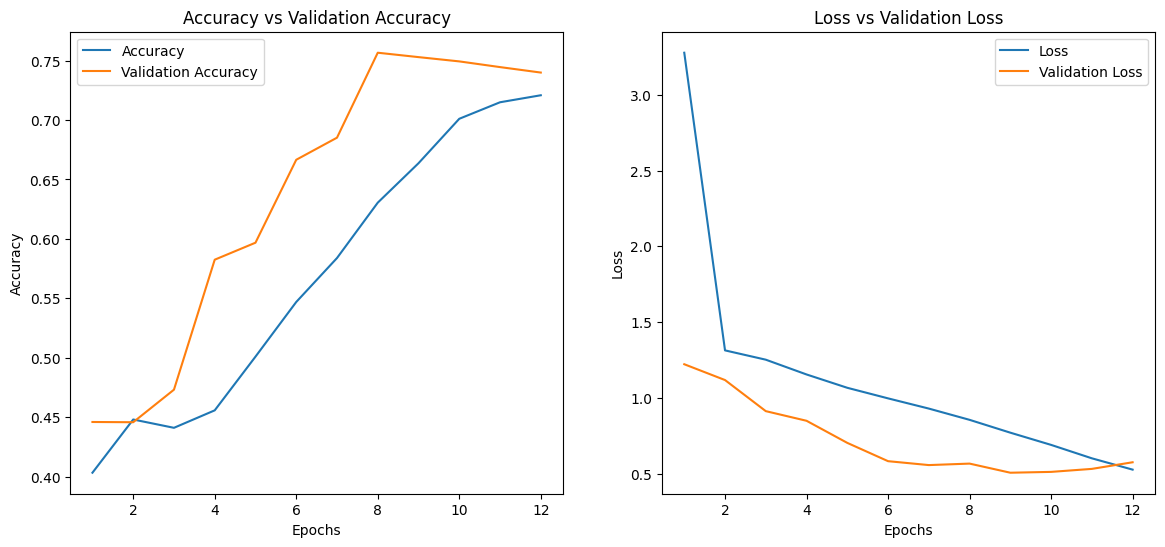

In [41]:
import matplotlib.pyplot as plt

df          = pd.DataFrame(history.history)
df['epoch'] = df.index + 1

# Extracting the data from the given log
epochs = df['epoch']
accuracy = df['accuracy']
val_accuracy = df['val_accuracy']
loss = df['loss']
val_loss = df['val_loss']

# Plotting accuracy and validation accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Validation Accuracy')
plt.legend()

# Plotting loss and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Validation Loss')
plt.legend()

# Save the plot
plt.savefig('training_performance.png')

# Show the plot
plt.show()
